In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

df = pd.read_excel('Needs.xls')

seed = 69

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

In [3]:
df.drop(labels='ID', axis=1, inplace=True)

In [4]:
df = df.sample(frac = 1, random_state = seed)

x_df = df[['Age', 'Gender', 'FamilyMembers', 'FinancialEducation', 'RiskPropensity', 'Income', 'Wealth']]
y_inc_df = df['IncomeInvestment']
y_acc_df = df['AccumulationInvestment']

In [5]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_inc_train, y_inc_test = train_test_split(x_df, y_inc_df, test_size=0.15, random_state=seed)
x_train, x_test, y_acc_train, y_acc_test = train_test_split(x_df, y_acc_df, test_size=0.15, random_state=seed)

# Data Exploration

Feature distributions are plotted.

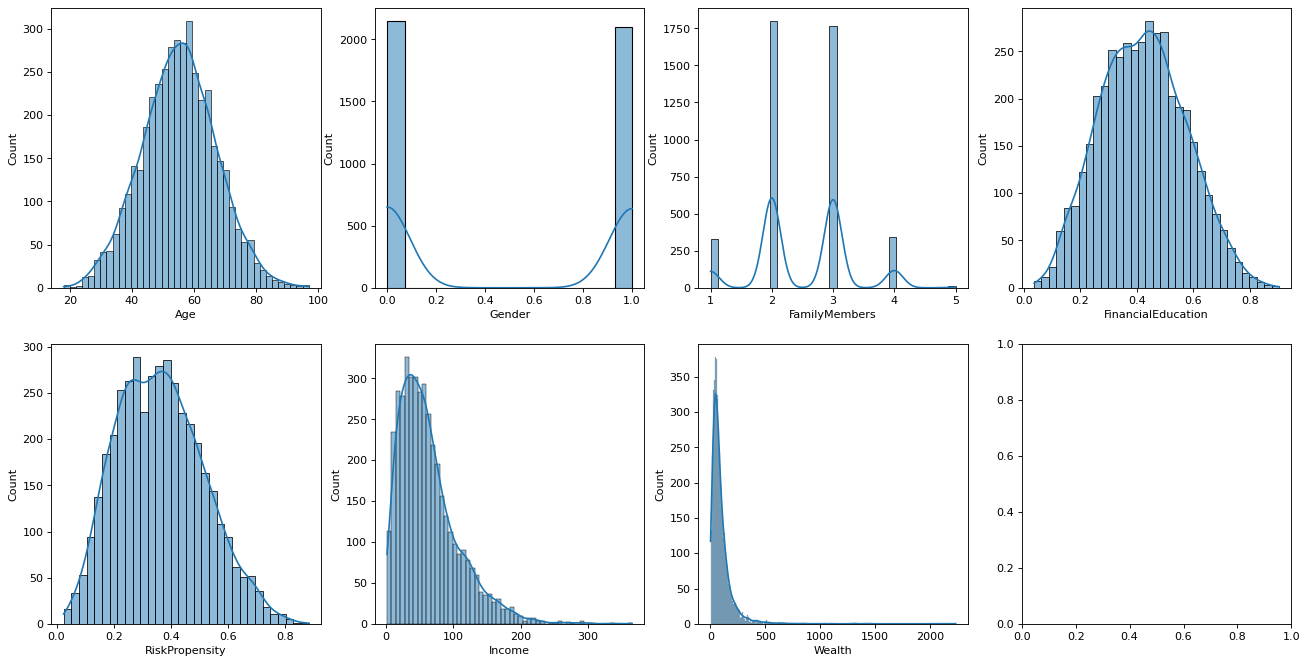

In [6]:
# defining the number of subplots per row and column
n_rows = 2
n_cols = 4

# creating the figure and the set of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20,10), dpi=80)
features = x_train.columns

# initializing the row and column indexes
row = column = 0

# for each feature: select the correct axis, plot the feature distribution and update the indexes
for f in features:
    ax = axes[row][column]

    sns.histplot(data=x_train, x=f, ax=ax, kde=True)

    column = column + 1
    if column % n_cols == 0:
        column = 0
        row = row + 1

The scatterplots of each feature versus the other using the labels <code>IncomeInvestment</code> and <code>AccumulationInvestment</code> as grouping variables are plotted. This is done mainly to determine whether one or more features could be considered useless for classification purposes.

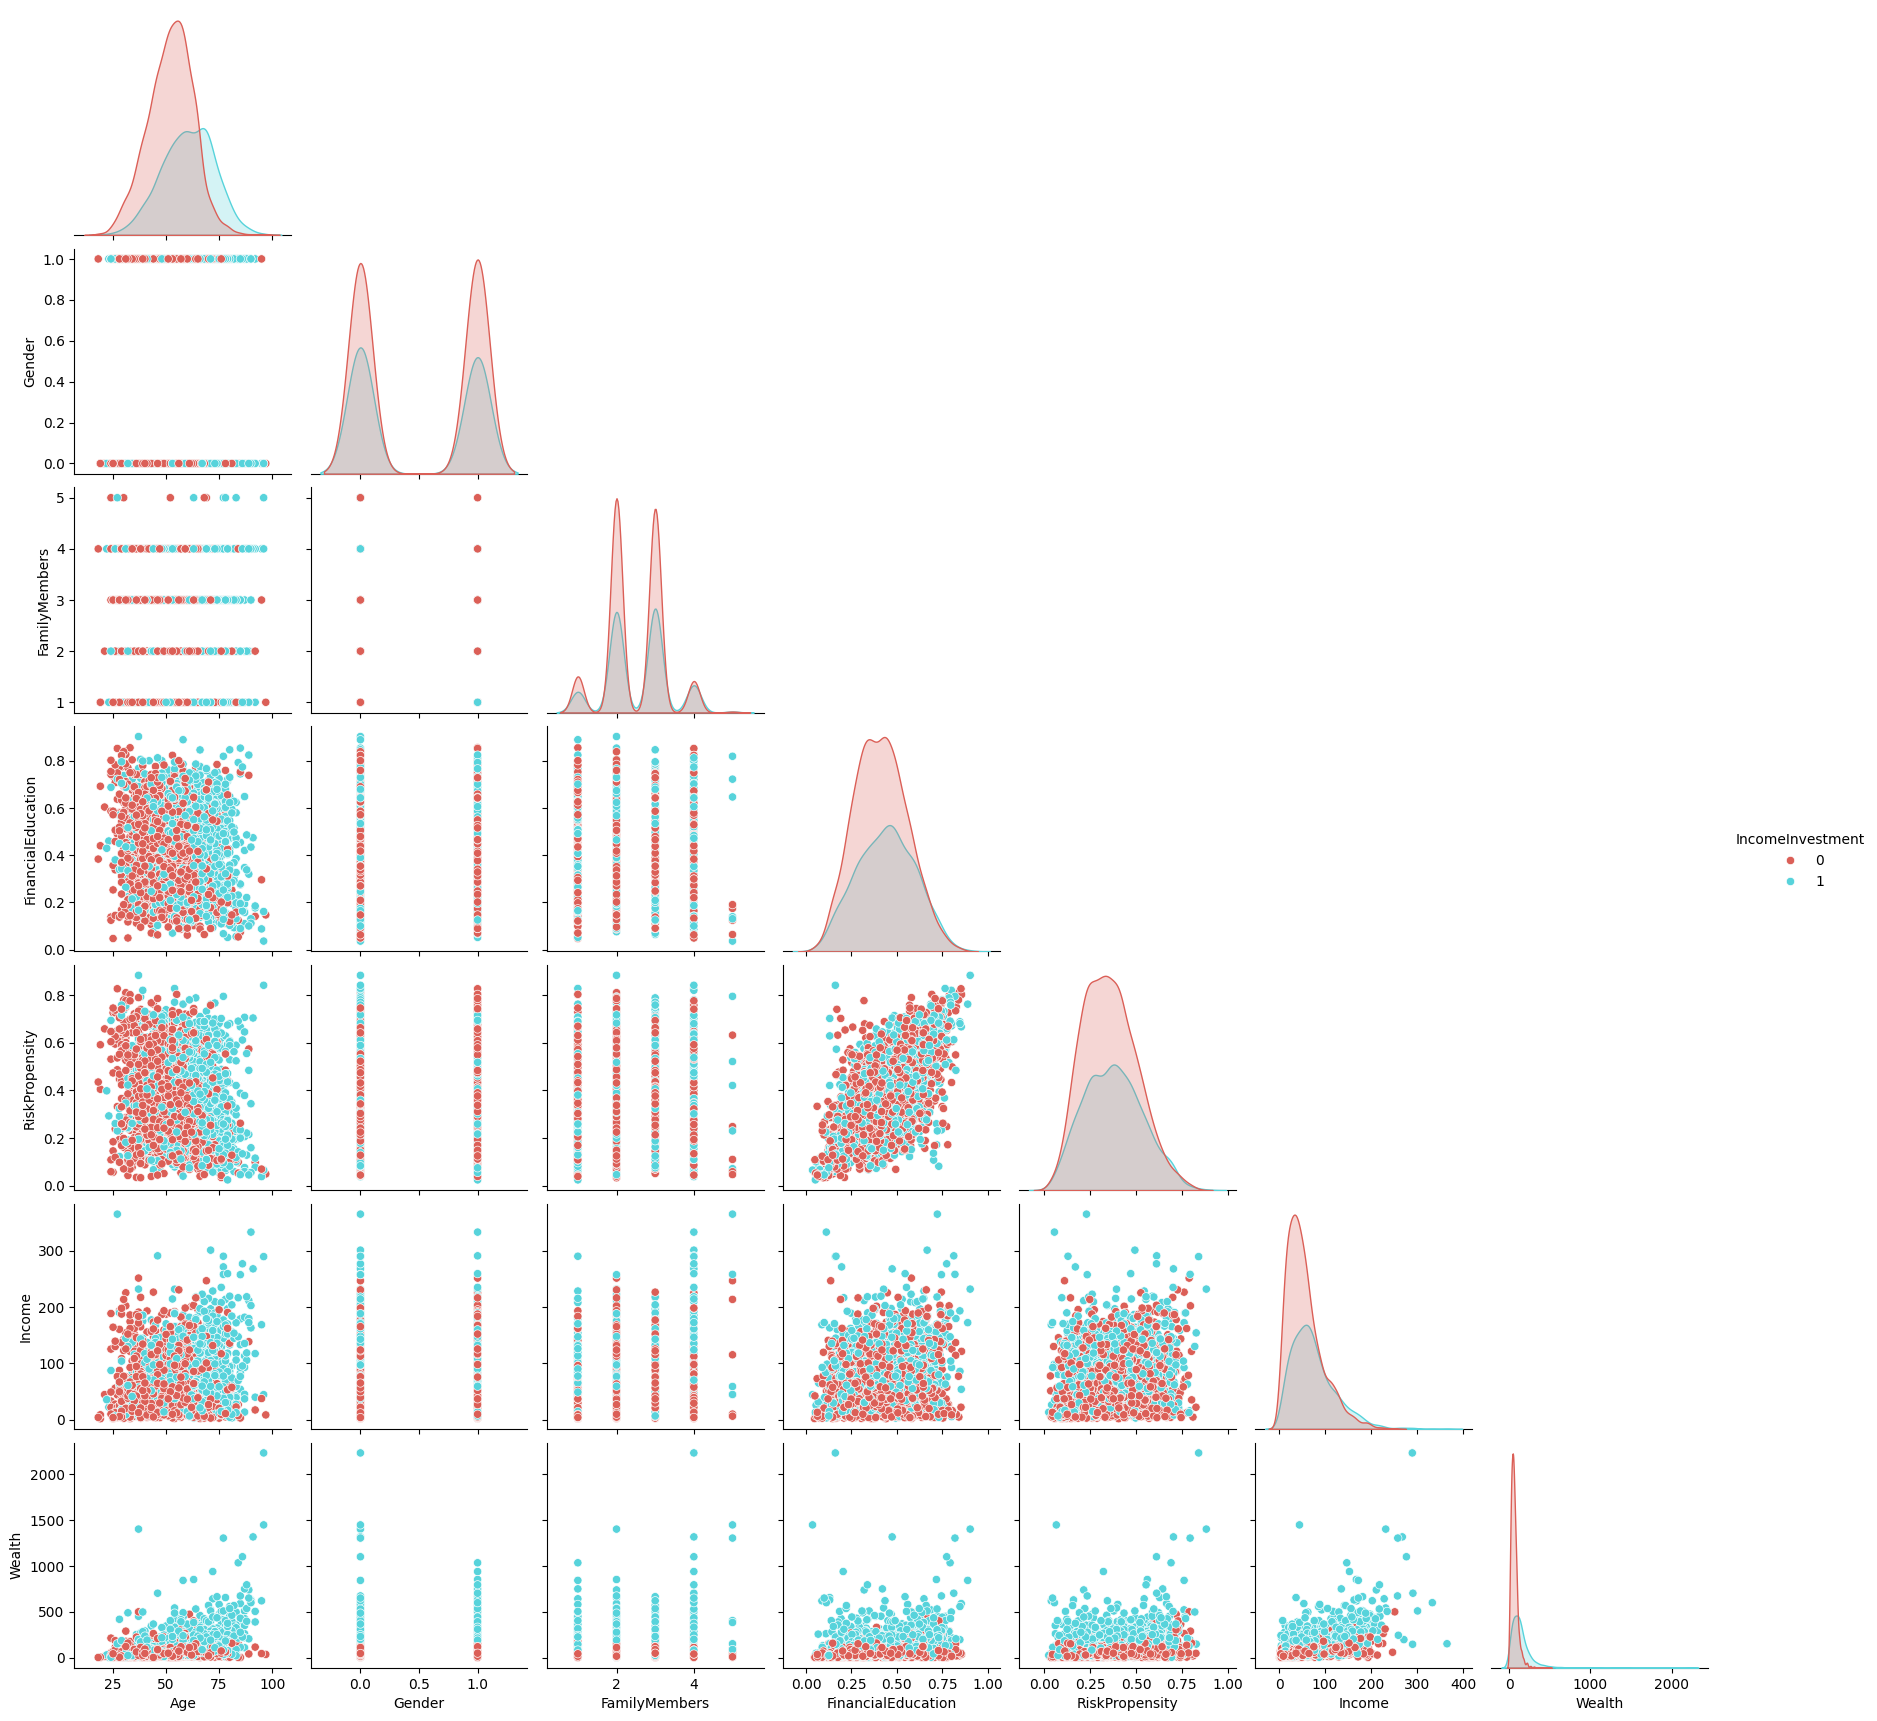

In [7]:
colour = sns.color_palette("hls", 2) # 2 is the number of possible values of IncomeInvestment feature
_ = sns.pairplot(pd.concat([x_train, y_inc_train], axis = 1),
             hue= 'IncomeInvestment',
             corner = True,
             palette = colour,
             vars = ['Age', 'Gender', 'FamilyMembers', 'FinancialEducation', 'RiskPropensity', 'Income', 'Wealth'])

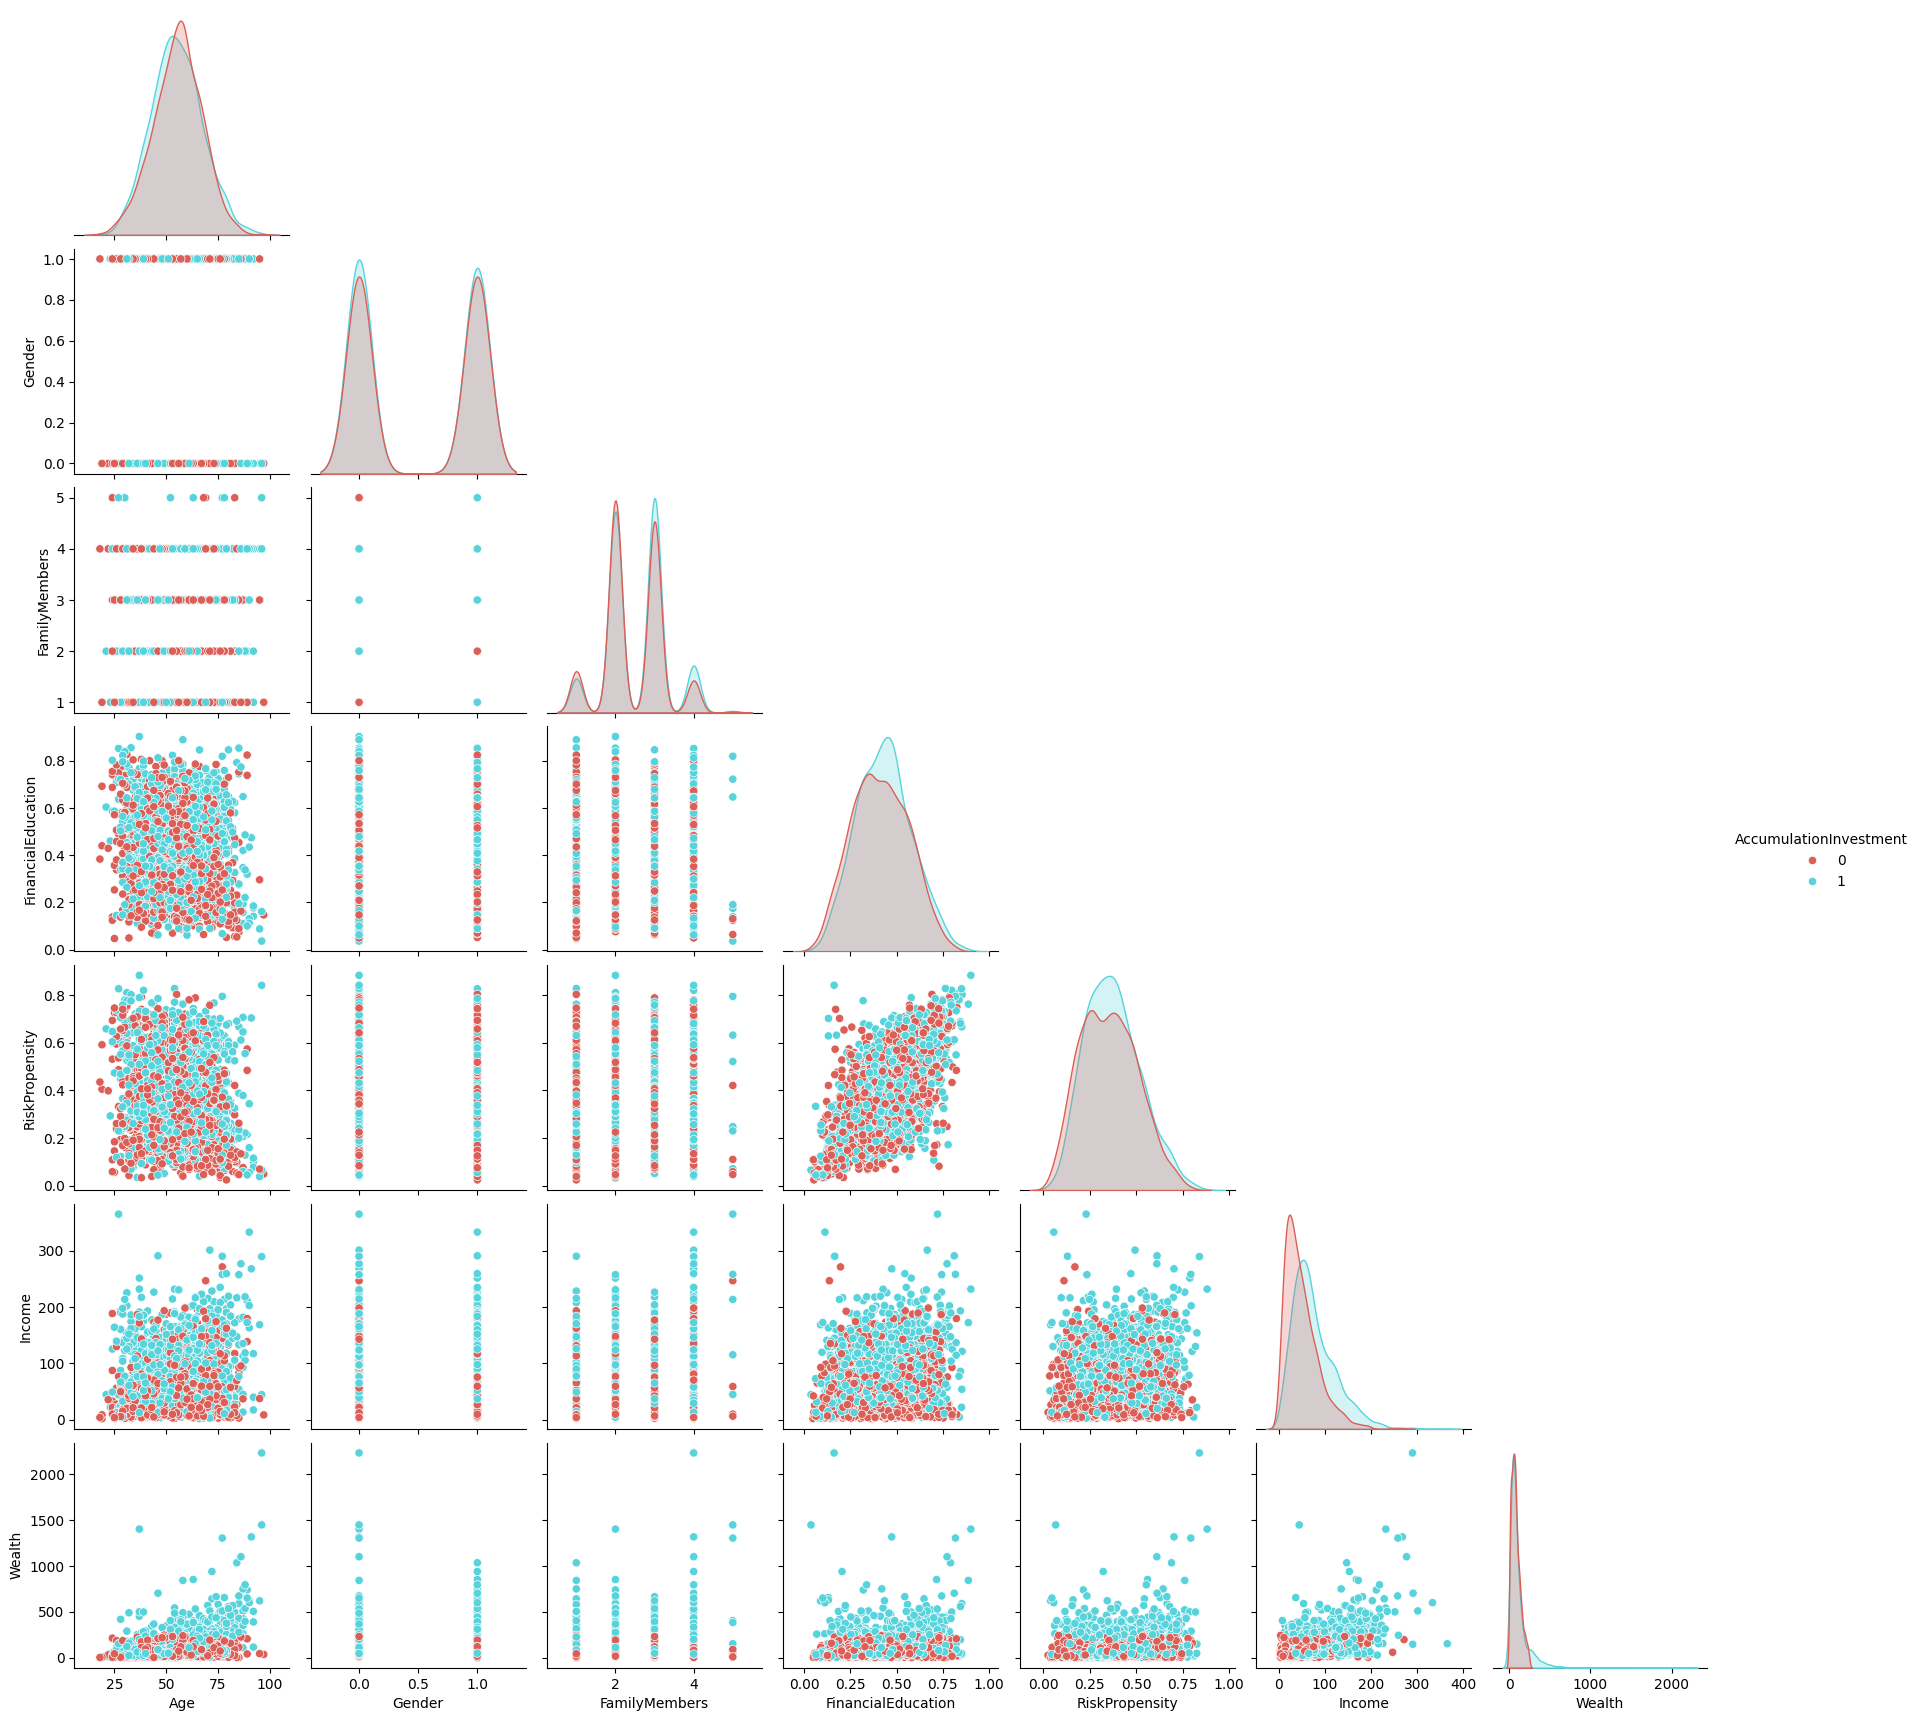

In [8]:
colour = sns.color_palette("hls", 2) # 2 is the number of possible values of AccumulationInvestment feature
_ = sns.pairplot(pd.concat([x_train, y_acc_train], axis = 1),
             hue= 'AccumulationInvestment',
             corner = True,
             palette = colour,
             vars = ['Age', 'Gender', 'FamilyMembers', 'FinancialEducation', 'RiskPropensity', 'Income', 'Wealth'])

From the multivariate plots it is possibile to notice that <code>Gender</code> feature and <code>FamilyMembers</code> features are not particularly relevant in order to establish weather a client is inclined towards accumulation investments or income investments.

# Data preprocessing

<code>Gender</code> and <code>FamilyMembers</code> features are dropped since they showed little relevance in data exploration.

In [9]:
for x in [x_train, x_test]:
    x.drop(labels='Gender', axis=1, inplace=True)
    x.drop(labels='FamilyMembers', axis=1, inplace=True)

Data exploration showed that <code>Wealth</code> and <code>Income</code> features are not gaussian distributed. A power law transformation is applied in order to modify the distribution related to these features. $0.1$ and $0.3$ values showed to work well in the two cases (transformed features are approximately gaussian distributed).

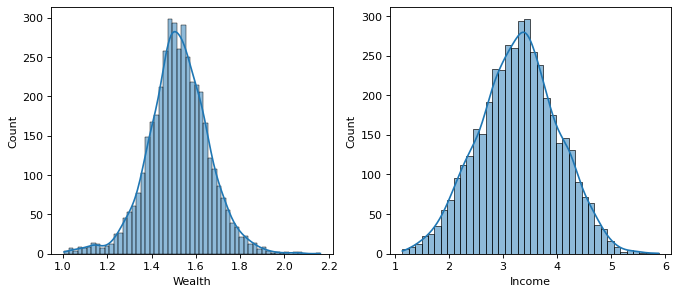

In [10]:
wealth_power = 0.1
income_power = 0.3

for x in [x_train, x_test]:
    x['Wealth'] = x['Wealth']**wealth_power
    x['Income'] = x['Income']**income_power

fig, axes = plt.subplots(1, 2, figsize=(10,4), dpi=80)
_ = sns.histplot(data=x_train, x='Wealth', ax=axes[0], kde=True)
_ = sns.histplot(data=x_train, x='Income', ax=axes[1], kde=True)

Standardization ($\mu =0\text{, }\sigma ^2=1$) is applied feature-wise to the dataframe. Mean and standard deviation values (evaluated on training set) are stored since they may be useful later to transform back to the original values.

In [12]:
features = x_train.columns
indexes = np.arange(len(features))

means = np.empty(len(features))
stds = np.empty(len(features))

for f, i in zip(features, indexes):
    means[i] = np.mean(x_train[f])
    stds[i] = np.std(x_train[f])
    for x in [x_train, x_test]:
        x[f] = (x[f] - means[i]) / stds[i]

# Classification

## Logistic regression (part 1)

Logistic regression is used as a first classification model. Two different classifiers are trained for <code>IncomeInvestment</code> and <code>AccumulationInvestment</code> targets.

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict

# defining the logistic regression estimator
log_reg_inc = LogisticRegression(random_state = seed)
log_reg_acc = LogisticRegression(random_state = seed)

# fitting for income investment
_ = log_reg_inc.fit(x_train, y_inc_train)
y_inc_pred = cross_val_predict(log_reg_inc, x_train, y_inc_train, cv = 10)

# fitting for accumulation investment
_ = log_reg_acc.fit(x_train, y_acc_train)
y_acc_pred = cross_val_predict(log_reg_acc, x_train, y_acc_train, cv = 10)

### Results visualization

Confusion matrix and metrics are plotted.

Income Investment Propensity metrics:
Accuracy:	0.772
Recall:		0.582
Precision:	0.770
F1score:	0.663


Accumulation Investment Propensity metrics:
Accuracy:	0.658
Recall:		0.691
Precision:	0.659
F1score:	0.675




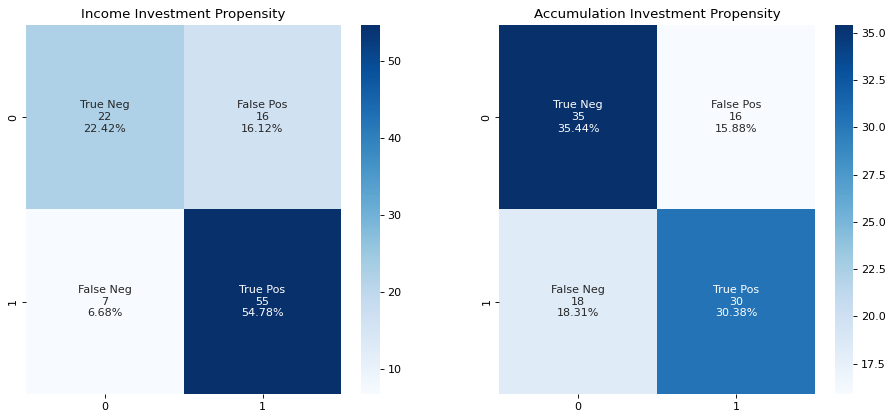

In [14]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

fig, axes = plt.subplots(1, 2, figsize=(14,6), dpi=80)
title = ['Income Investment Propensity', 'Accumulation Investment Propensity']

for y_train, y_pred, i in zip([y_inc_train, y_acc_train], [y_inc_pred, y_acc_pred], [0, 1]):

    cf_matrix = (confusion_matrix(y_train, y_pred, labels=[1, 0], sample_weight=None) / len(y_pred) * 100)

    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    _ = sns.heatmap(cf_matrix, annot=labels, fmt='', ax=axes[i], cmap='Blues')
    axes[i].set_title(title[i])

    print(f'{title[i]} metrics:')
    print(f'Accuracy:\t{accuracy_score(y_train, y_pred):.3f}')
    print(f'Recall:\t\t{recall_score(y_train, y_pred):.3f}')
    print(f'Precision:\t{precision_score(y_train, y_pred):.3f}')
    print(f'F1score:\t{f1_score(y_train, y_pred):.3f}')
    print('\n')

<code>Commenti sui risultati ottenuti dal primo modello</code>

## Feature Engineering

Normalization and power transformation are reversed before creating <code>wealth/income</code> variable and plotting it.

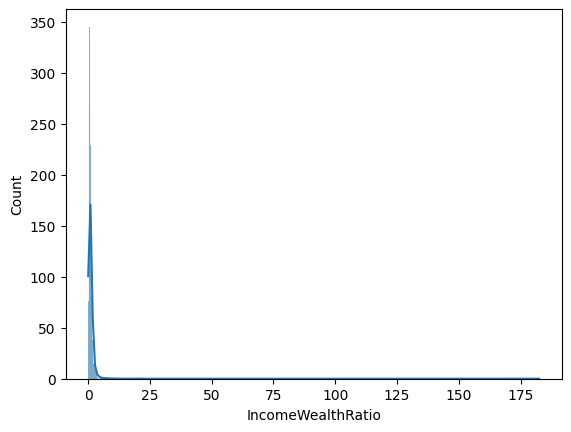

In [15]:
for f, i in zip(features, indexes):
    for x in [x_train, x_test]:
        x[f] = x[f] * stds[i] + means[i]

for x in [x_train, x_test]:
    x['Wealth'] = x['Wealth']**(1.0/wealth_power)
    x['Income'] = x['Income']**(1.0/income_power)
    x['IncomeWealthRatio'] = x['Income'] / x['Wealth']

_ = sns.histplot(data=x_train, x='IncomeWealthRatio', kde=True)

The power transformation is applied to <code>wealth/income</code> variable to modify its distribution to gaussian-like.

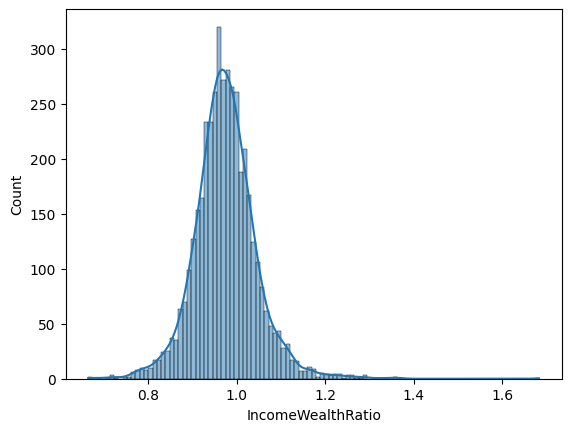

In [16]:
wealth_income_power = 0.1

for x in [x_train, x_test]:
    x['IncomeWealthRatio'] = x['IncomeWealthRatio']**wealth_income_power

_ = sns.histplot(data=x_train, x='IncomeWealthRatio', kde=True)

The data preprocessing already discussed above is re-applied to data in order to prepare it for classification.

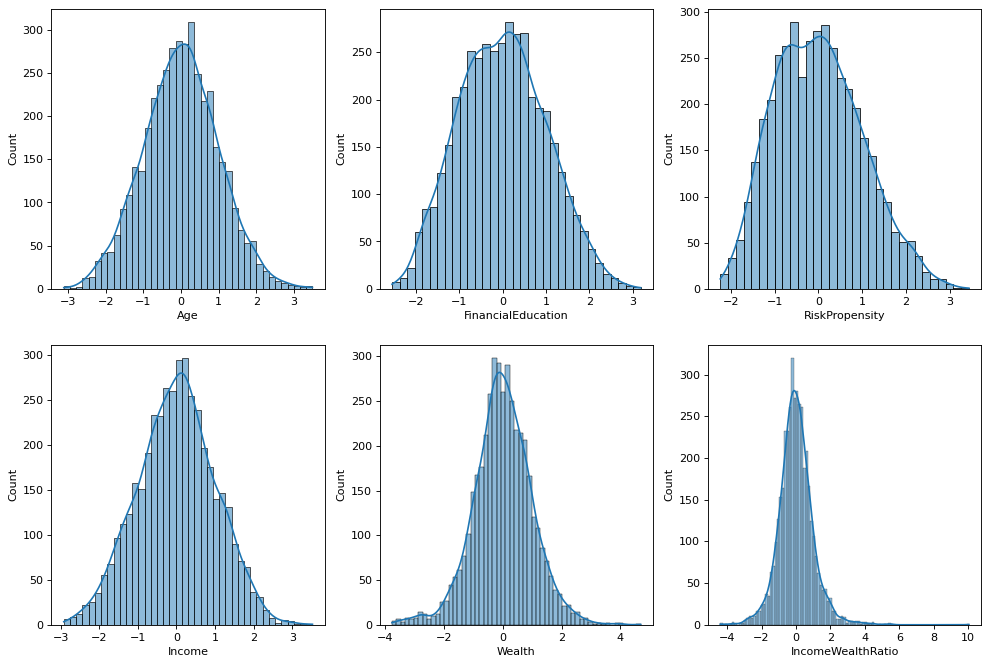

In [17]:
for x in [x_train, x_test]:
    x['Wealth'] = x['Wealth']**wealth_power
    x['Income'] = x['Income']**income_power

features = x_train.columns
indexes = np.arange(len(features))

means = np.empty(len(features))
stds = np.empty(len(features))

for f, i in zip(features, indexes):
    means[i] = np.mean(x_train[f])
    stds[i] = np.std(x_train[f])
    for x in [x_train, x_test]:
        x[f] = (x[f] - means[i]) / stds[i]

# defining the number of subplots per row and column
n_rows = 2
n_cols = 3

# creating the figure and the set of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15,10), dpi=80)

# initializing the row and column indexes
row = column = 0

# for each feature: select the correct axis, plot the feature distribution and update the indexes
for f in features:
    ax = axes[row][column]

    sns.histplot(data=x_train, x=f, ax=ax, kde=True)

    column = column + 1
    if column % n_cols == 0:
        column = 0
        row = row + 1

## Logistic regression (part 2)

Logistic regression is fitted again on new training data.

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict

# defining the logistic regression estimator
log_reg_inc = LogisticRegression(random_state = seed)
log_reg_acc = LogisticRegression(random_state = seed)

# fitting for income investment
_ = log_reg_inc.fit(x_train, y_inc_train)
y_inc_pred = cross_val_predict(log_reg_inc, x_train, y_inc_train, cv = 10)

# fitting for accumulation investment
_ = log_reg_acc.fit(x_train, y_acc_train)
y_acc_pred = cross_val_predict(log_reg_acc, x_train, y_acc_train, cv = 10)

Income Investment Propensity metrics:
Accuracy:	0.779
Recall:		0.585
Precision:	0.787
F1score:	0.672
True Neg:	22.56%
False Pos:	15.98%
False Neg:	6.09%
True Pos:	55.36%


Accumulation Investment Propensity metrics:
Accuracy:	0.658
Recall:		0.700
Precision:	0.656
F1score:	0.677
True Neg:	35.93%
False Pos:	15.39%
False Neg:	18.85%
True Pos:	29.84%




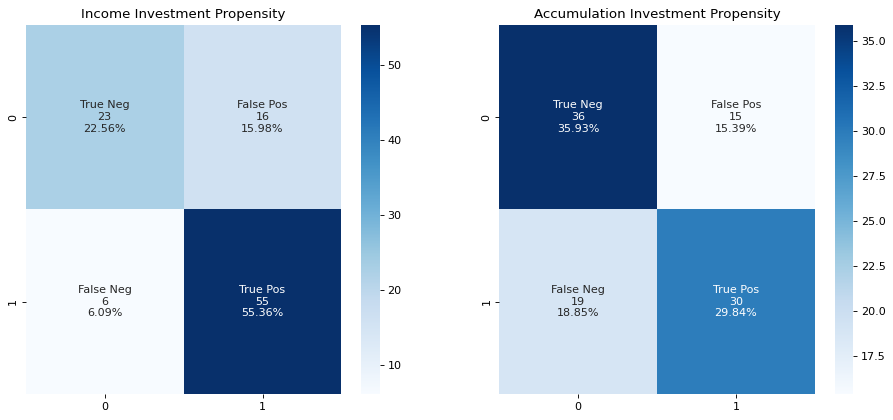

In [19]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

fig, axes = plt.subplots(1, 2, figsize=(14,6), dpi=80)
title = ['Income Investment Propensity', 'Accumulation Investment Propensity']

for y_train, y_pred, i in zip([y_inc_train, y_acc_train], [y_inc_pred, y_acc_pred], [0, 1]):

    cf_matrix = (confusion_matrix(y_train, y_pred, labels=[1, 0], sample_weight=None) / len(y_pred) * 100)

    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    _ = sns.heatmap(cf_matrix, annot=labels, fmt='', ax=axes[i], cmap='Blues')
    axes[i].set_title(title[i])

    print(f'{title[i]} metrics:')
    print(f'Accuracy:\t{accuracy_score(y_train, y_pred):.3f}')
    print(f'Recall:\t\t{recall_score(y_train, y_pred):.3f}')
    print(f'Precision:\t{precision_score(y_train, y_pred):.3f}')
    print(f'F1score:\t{f1_score(y_train, y_pred):.3f}')
    for var, val in zip(group_names, group_percentages):
        print(f'{var}:\t{val}')
    print('\n')

This new model is not significantly better with respect to the previous one. Other techniques are tried out in order to improve classification performance.

## Random forest

<code>Insert description of the procedure here</code>

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

max_depth_list = [6, 8, 10, 12]
n_estimators_list = [75, 125, 175]
min_samples_split_list = [2, 6, 10]

best_max_depth = ['', '']
best_n_estimators = ['', '']
best_min_samples_split = ['', '']

title = ['Income Investment Propensity', 'Accumulation Investment Propensity']

for y_train, i in zip([y_inc_train, y_acc_train], [0, 1]):

    f1 = 0

    for max_depth in max_depth_list:
        for n_estimators in n_estimators_list:
            for min_samples_split in min_samples_split_list:

                rand_forest = RandomForestClassifier(n_estimators = n_estimators,
                                                     min_samples_split = min_samples_split,
                                                     criterion = 'entropy',
                                                     random_state = seed,
                                                     max_depth = max_depth)
                rand_forest.fit(x_train, y_train)
                y_pred = cross_val_predict(rand_forest, x_train, y_train, cv = 10)

                if(f1_score(y_train, y_pred) > f1):
                    best_max_depth[i] = max_depth
                    best_n_estimators[i] = n_estimators
                    best_min_samples_split[i] = min_samples_split
                    f1 = f1_score(y_train, y_pred)

    print(title[i])
    print(f'Best max_depth:\t{best_max_depth[i]}')
    print(f'Best n_estimators:\t{best_n_estimators[i]}')
    print(f'Best min_samples_split:\t{best_min_samples_split[i]}')
    print(f'F1score:\t{f1}')
    print('\n')

Income Investment Propensity
Best max_depth:	12
Best n_estimators:	125
Best min_samples_split:	6
F1score:	0.7189208895370033


Accumulation Investment Propensity
Best max_depth:	10
Best n_estimators:	125
Best min_samples_split:	10
F1score:	0.8212776534924185




Income Investment Propensity metrics:
Accuracy:	0.819
Recall:		0.602
Precision:	0.892
F1score:	0.719
True Neg:	23.20%
False Pos:	15.34%
False Neg:	2.80%
True Pos:	58.66%


Accumulation Investment Propensity metrics:
Accuracy:	0.831
Recall:		0.757
Precision:	0.897
F1score:	0.821
True Neg:	38.87%
False Pos:	12.45%
False Neg:	4.47%
True Pos:	44.21%




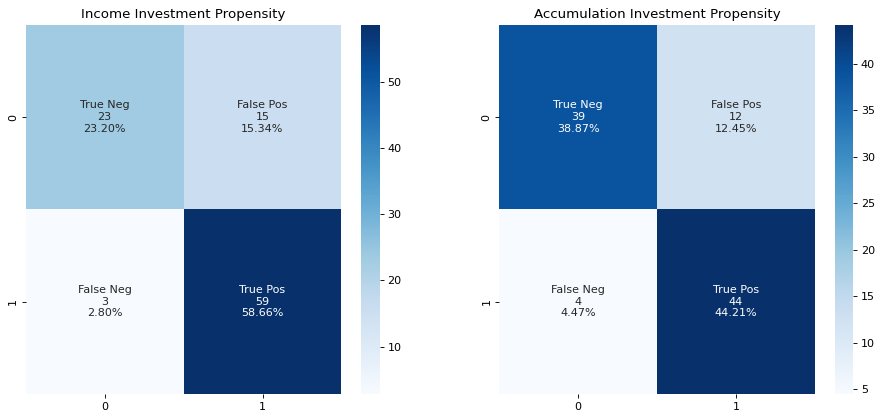

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

best_criterion = ['entropy', 'entropy']
best_max_depth = [12, 10]
best_n_estimators = [125, 125]
best_min_samples_split = [6, 10]

fig, axes = plt.subplots(1, 2, figsize=(14,6), dpi=80)
title = ['Income Investment Propensity', 'Accumulation Investment Propensity']

for y_train, y_pred, i in zip([y_inc_train, y_acc_train], [y_inc_pred, y_acc_pred], [0, 1]):

    rand_forest = RandomForestClassifier(n_estimators = best_n_estimators[i],
                                         min_samples_split = best_min_samples_split[i],
                                         criterion = best_criterion[i],
                                         random_state = seed,
                                         max_depth = best_max_depth[i])
    rand_forest.fit(x_train, y_train)
    y_pred = cross_val_predict(rand_forest, x_train, y_train, cv = 10)

    cf_matrix = (confusion_matrix(y_train, y_pred, labels=[1, 0], sample_weight=None) / len(y_pred) * 100)

    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    _ = sns.heatmap(cf_matrix, annot=labels, fmt='', ax=axes[i], cmap='Blues')
    axes[i].set_title(title[i])

    print(f'{title[i]} metrics:')
    print(f'Accuracy:\t{accuracy_score(y_train, y_pred):.3f}')
    print(f'Recall:\t\t{recall_score(y_train, y_pred):.3f}')
    print(f'Precision:\t{precision_score(y_train, y_pred):.3f}')
    print(f'F1score:\t{f1_score(y_train, y_pred):.3f}')
    for var, val in zip(group_names, group_percentages):
        print(f'{var}:\t{val}')
    print('\n')

Results on the test set

Income Investment Propensity metrics:
Accuracy:	0.825
Recall:		0.607
Precision:	0.890
F1score:	0.722


Accumulation Investment Propensity metrics:
Accuracy:	0.831
Recall:		0.735
Precision:	0.919
F1score:	0.817




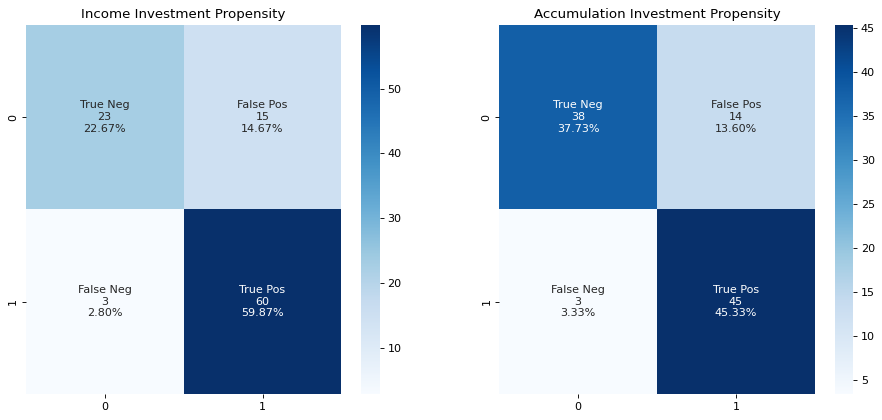

In [22]:
best_criterion = ['entropy', 'entropy']
best_max_depth = [12, 10]
best_n_estimators = [125, 125]
best_min_samples_split = [6, 10]

fig, axes = plt.subplots(1, 2, figsize=(14,6), dpi=80)
title = ['Income Investment Propensity', 'Accumulation Investment Propensity']

for y_train, y_pred, y_test, i in zip([y_inc_train, y_acc_train], [y_inc_pred, y_acc_pred], [y_inc_test, y_acc_test], [0, 1]):

    rand_forest = RandomForestClassifier(n_estimators = best_n_estimators[i],
                                         min_samples_split = best_min_samples_split[i],
                                         criterion = best_criterion[i],
                                         random_state = seed,
                                         max_depth = best_max_depth[i])
    rand_forest.fit(x_train, y_train)
    y_pred = rand_forest.predict(x_test)

    cf_matrix = (confusion_matrix(y_test, y_pred, labels=[1, 0], sample_weight=None) / len(y_pred) * 100)

    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    _ = sns.heatmap(cf_matrix, annot=labels, fmt='', ax=axes[i], cmap='Blues')
    axes[i].set_title(title[i])

    print(f'{title[i]} metrics:')
    print(f'Accuracy:\t{accuracy_score(y_test, y_pred):.3f}')
    print(f'Recall:\t\t{recall_score(y_test, y_pred):.3f}')
    print(f'Precision:\t{precision_score(y_test, y_pred):.3f}')
    print(f'F1score:\t{f1_score(y_test, y_pred):.3f}')
    print('\n')

Feature importances plot.

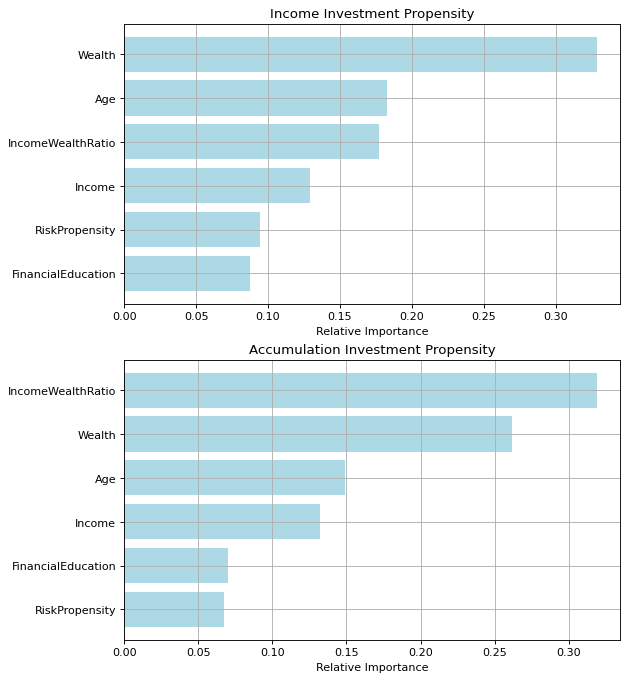

In [23]:
fig, axes = plt.subplots(2, 1, figsize=(8,10), dpi=80)
title = ['Income Investment Propensity', 'Accumulation Investment Propensity']

for y_train, y_pred, y_test, i in zip([y_inc_train, y_acc_train], [y_inc_pred, y_acc_pred], [y_inc_test, y_acc_test], [0, 1]):

    rand_forest = RandomForestClassifier(n_estimators = best_n_estimators[i],
                                         min_samples_split = best_min_samples_split[i],
                                         criterion = best_criterion[i],
                                         random_state = seed,
                                         max_depth = best_max_depth[i])
    rand_forest.fit(x_train, y_train)

    importances = rand_forest.feature_importances_
    indices = np.argsort(importances)
    features = x_train.columns
    axes[i].set_title(title[i])
    axes[i].barh(range(len(indices)), importances[indices], color='lightblue', align='center')
    axes[i].set_yticks(range(len(indices)), [features[index] for index in indices])
    axes[i].set_xlabel('Relative Importance')
    axes[i].grid()

Shapley values.

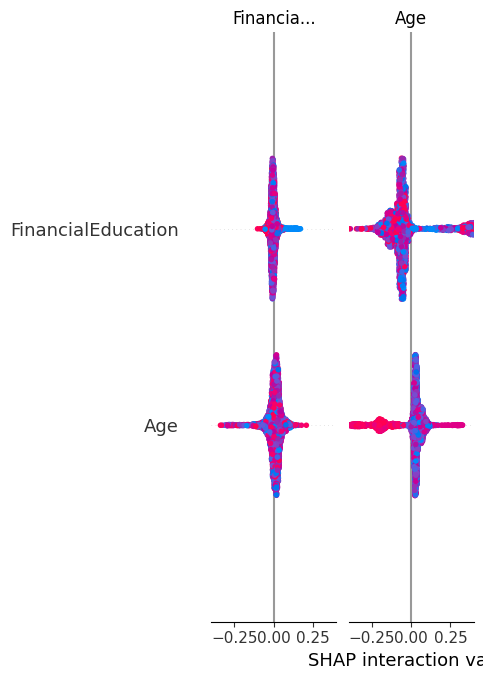

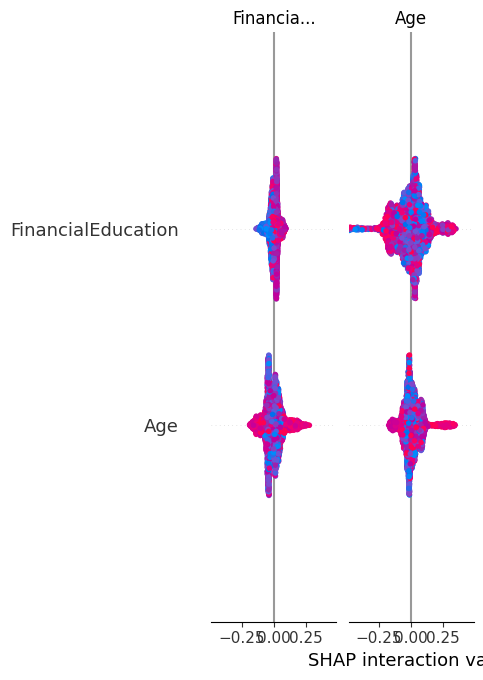

In [24]:
from shap import TreeExplainer, summary_plot

title = ['Income Investment Propensity', 'Accumulation Investment Propensity']

for y_train, i in zip([y_inc_train, y_acc_train], [0, 1]):

    rand_forest = RandomForestClassifier(n_estimators = best_n_estimators[i],
                                         min_samples_split = best_min_samples_split[i],
                                         criterion = best_criterion[i],
                                         random_state = seed,
                                         max_depth = best_max_depth[i])
    rand_forest.fit(x_train, y_train)

    rf_explainer = TreeExplainer(rand_forest)
    shap_values = rf_explainer.shap_values(x_train)
    summary_plot(shap_values, x_train)

##### Parameter selection

Note: this is done using the validation set, it should be rivesed in order to fit cross-validation instead.

In [ ]:
""" # Decode the depth of the tree with validation set
# max_depths = [1,3,6,9,12,15,18,21,]
max_depths = [1,3,5,6,7,8,9,10,11,12,13,15]
# y_inc_train,y_acc_train
# y_inc_val,y_acc_val
training_error = []
validation_error = []
for max_depth in max_depths:
    #rf = RandomForestRegressor(max_depth=max_depth)
    rf=RandomForestClassifier(max_depth=max_depth, n_estimators = 125, min_samples_split = 2, random_state = seed)
    rf.fit(x_train, y_inc_train)
    training_error.append(f1_score(y_inc_train, rf.predict(x_train)))
    validation_error.append(f1_score(y_inc_val, rf.predict(x_val)))


# Plot the training error and the validation error

fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111)

ax.plot(max_depths, training_error, label='Training error')
ax.plot(max_depths, validation_error, color='goldenrod', label='Validation error')
ax.set_xlabel('max_depth')
ax.axvline(x=6, ymax=0.9,color='crimson', linestyle='dashed')
ax.axhline(y=0.0249,color='grey', linestyle='dotted')
ax.annotate('optimum = 6', xy=(4, 0.023), color='crimson')
ax.set_ylabel('F1')
ax.set_title('Hyperparameter tuning: max_depth', pad=15, size=12)
ax.legend()
# plt.grid(linewidth=0.25)
plt.savefig('RFTuning_maxdepth.eps', format='eps') """

## AdaBoost

AdaBoost with decision trees.

Income Investment Propensity metrics:
Accuracy:	0.775
Recall:		0.617
Precision:	0.755
F1score:	0.679


Accumulation Investment Propensity metrics:
Accuracy:	0.790
Recall:		0.675
Precision:	0.889
F1score:	0.767




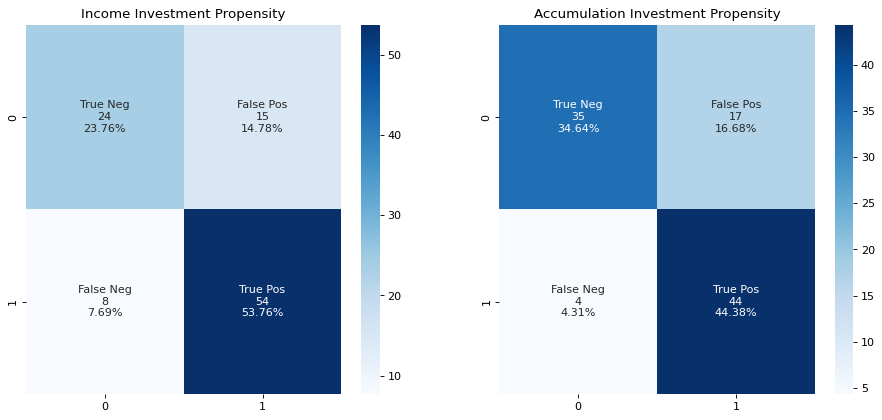

In [25]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

n_estimators = 200

fig, axes = plt.subplots(1, 2, figsize=(14,6), dpi=80)
title = ['Income Investment Propensity', 'Accumulation Investment Propensity']

adaboost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators = n_estimators, random_state = seed)

for y_train, i in zip([y_inc_train, y_acc_train], [0, 1]):

    adaboost.fit(x_train, y_train)
    y_pred = cross_val_predict(adaboost, x_train, y_train, cv = 10)

    cf_matrix = (confusion_matrix(y_train, y_pred, labels=[1, 0], sample_weight=None) / len(y_pred) * 100)

    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    _ = sns.heatmap(cf_matrix, annot=labels, fmt='', ax=axes[i], cmap='Blues')
    axes[i].set_title(title[i])

    print(f'{title[i]} metrics:')
    print(f'Accuracy:\t{accuracy_score(y_train, y_pred):.3f}')
    print(f'Recall:\t\t{recall_score(y_train, y_pred):.3f}')
    print(f'Precision:\t{precision_score(y_train, y_pred):.3f}')
    print(f'F1score:\t{f1_score(y_train, y_pred):.3f}')
    print('\n')

AdaBoost with perceptron.

Income Investment Propensity metrics:
Accuracy:	0.738
Recall:		0.562
Precision:	0.700
F1score:	0.623


Accumulation Investment Propensity metrics:
Accuracy:	0.579
Recall:		0.685
Precision:	0.576
F1score:	0.625




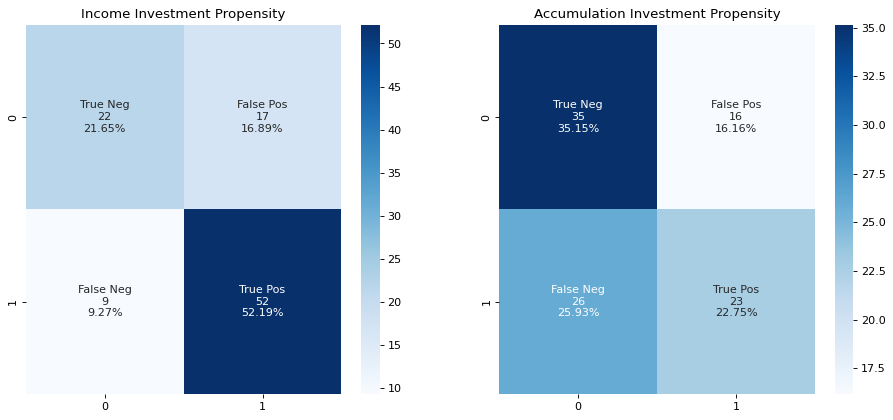

In [26]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import Perceptron

n_estimators = 200

fig, axes = plt.subplots(1, 2, figsize=(14,6), dpi=80)
title = ['Income Investment Propensity', 'Accumulation Investment Propensity']

adaboost = AdaBoostClassifier(Perceptron(random_state = seed), n_estimators = n_estimators, random_state = seed, algorithm = 'SAMME')

for y_train, i in zip([y_inc_train, y_acc_train], [0, 1]):

    adaboost.fit(x_train, y_train)
    y_pred = cross_val_predict(adaboost, x_train, y_train, cv = 10)

    cf_matrix = (confusion_matrix(y_train, y_pred, labels=[1, 0], sample_weight=None) / len(y_pred) * 100)

    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    _ = sns.heatmap(cf_matrix, annot=labels, fmt='', ax=axes[i], cmap='Blues')
    axes[i].set_title(title[i])

    print(f'{title[i]} metrics:')
    print(f'Accuracy:\t{accuracy_score(y_train, y_pred):.3f}')
    print(f'Recall:\t\t{recall_score(y_train, y_pred):.3f}')
    print(f'Precision:\t{precision_score(y_train, y_pred):.3f}')
    print(f'F1score:\t{f1_score(y_train, y_pred):.3f}')
    print('\n')

# Recommendation system

The products list is read from the excel file.

In [27]:
products = pd.read_excel('Needs.xls', 'Products')

The products list is split between <code>income_products</code> and <code>accumulation_products</code>.

In [28]:
income_products = products[products['Type'] == 1]
accumulation_products = products[products['Type'] == 0]

The products are sorted in increasing <code>Risk</code> order.

In [29]:
income_products.sort_values('Risk', axis = 0, inplace=True)
accumulation_products.sort_values('Risk', axis = 0, inplace=True)

The minimum and maximum <code>RiskPropensity</code> values are inspected from the dataset in order to establish lower and upper bouds.

In [30]:
max_risk = np.max(df['RiskPropensity'])
min_risk = np.min(df['RiskPropensity'])
print(f'max risk = {max_risk:.3f}')
print(f'min risk = {min_risk:.3f}')

max risk = 0.883
min risk = 0.025


Adding <code>MinRisk</code> and <code>MaxRisk</code> columns to the products dataframes which will be used to assign products to clients.

In [31]:
for df in [income_products, accumulation_products]:

    lower_bound = []
    upper_bound = []

    for i in range(len(df['Risk'])):
        if (i==0):
            lower_bound.append(min_risk)
            upper_bound.append((df.iloc[i]['Risk'] + df.iloc[i+1]['Risk']) / 2.0)
        elif (i==len(df['Risk'])-1):
            lower_bound.append((df.iloc[i]['Risk'] + df.iloc[i-1]['Risk']) / 2.0)
            upper_bound.append(max_risk)
        else:
            lower_bound.append((df.iloc[i]['Risk'] + df.iloc[i-1]['Risk']) / 2.0)
            upper_bound.append((df.iloc[i]['Risk'] + df.iloc[i+1]['Risk']) / 2.0)

    df['MinRisk'] = lower_bound
    df['MaxRisk'] = upper_bound

Using on the risk values the same normalization used on <code>RiskPropensity</code> feature of the training set.

In [32]:
features = list(x_train.columns)
risk_index = features.index('RiskPropensity')
risk_columns = ['Risk', 'MinRisk', 'MaxRisk']

for df in [income_products, accumulation_products]:
    for r in risk_columns:
        df[r] = (df[r] - means[risk_index]) / stds[risk_index]

In [33]:
print(income_products)
print('\n')
print(accumulation_products)

    IDProduct  Type      Risk   MinRisk   MaxRisk
8           9     1 -0.621428 -2.247205 -0.323072
5           6     1 -0.024716 -0.323072  0.141037
4           5     1  0.306791  0.141037  0.538845
7           8     1  0.770900  0.538845  1.002955
0           1     1  1.235010  1.002955  1.898023
6           7     1  2.561037  1.898023  2.991996
10         11     1  3.422955  2.991996  3.440918


   IDProduct  Type      Risk   MinRisk   MaxRisk
2          3     0 -1.615949 -2.247205 -1.582798
9         10     0 -1.549647 -1.582798 -0.986086
1          2     0 -0.422524 -0.986086  0.041585
3          4     0  0.505695  0.041585  3.440918


Defining the two classifiers for <code>income investment propensity</code> and <code>accumulation investment propensity</code>.

In [34]:
income_classifier = RandomForestClassifier(n_estimators = best_n_estimators[0],
                                           min_samples_split = best_min_samples_split[0],
                                           criterion = best_criterion[0],
                                           random_state = seed,
                                           max_depth = best_max_depth[0])
_ = income_classifier.fit(x_train, y_inc_train)

accumulation_classifier = RandomForestClassifier(n_estimators = best_n_estimators[1],
                                                 min_samples_split = best_min_samples_split[1],
                                                 criterion = best_criterion[1],
                                                 random_state = seed,
                                                 max_depth = best_max_depth[1])
_ = accumulation_classifier.fit(x_train, y_acc_train)

The function that assigns the best product to a client given the classifiers and the products dataframes is defined.

In [35]:
def assign_product(client, income_classifier, accumulation_classifier, income_products, accumulation_products):

    # with [:,1] I pick the probability of the client to have the prediction = 1
    inc_pred = income_classifier.predict_proba(client)[:,1]
    acc_pred = accumulation_classifier.predict_proba(client)[:,1]
    client_risk = client.iloc[0]['RiskPropensity']

    # if inc_pred > acc_pred then the client is more inclined towards income investments -> income product
    if (inc_pred >= acc_pred):
        for i in range(len(income_products['IDProduct'])):
            if (client_risk >= income_products.iloc[i]['MinRisk'] and client_risk <= income_products.iloc[i]['MaxRisk']):
                return income_products.iloc[i]['IDProduct']
    else:
        for i in range(len(accumulation_products['IDProduct'])):
            if (client_risk >= accumulation_products.iloc[i]['MinRisk'] and client_risk <= accumulation_products.iloc[i]['MaxRisk']):
                return accumulation_products.iloc[i]['IDProduct']

Defining the product dictionary

In [36]:
products = {1.0: 'Balanced Mutual Fund',
            2.0: 'Income Conservative Unit-Linked (Life Insurance)',
            3.0: 'Fixed Income Mutual Fund',
            4.0: 'Balanced High Dividend Mutual Fund',
            5.0: 'Balanced Mutual Fund',
            6.0: 'Defensive Flexible Allocation Unit-Linked (Life Insurance)',
            7.0: 'Aggressive Flexible Allocation Unit-Linked (Life Insurance)',
            8.0: 'Balanced Flexible Allocation Unit-Linkled (Life Insurance)',
            9.0: 'Cautious Allocation Segregated Account',
            10.0: 'Fixed Income Segregated Account',
            11.0: 'Total Return Aggressive Allocation Segregated Account'}

Trying to assign a product to the first client of the dataframe.

In [37]:
example_product = products[assign_product(client = x_train.head(1),
                                  income_classifier = income_classifier,
                                  accumulatio  n_classifier = accumulation_classifier,
                                  income_products = income_products,
                                  accumulation_products = accumulation_products)]

print(f'Product assigned to first client: {example_product}')

Product assigned to first client: Income Conservative Unit-Linked (Life Insurance)
